In [11]:
%load_ext autoreload
%autoreload 2 
# reload changes in modules without restarting the kernel
import pynetlogo
import numpy as np
import matplotlib.pyplot as plt
import json
import os,sys,datetime
import seaborn as sns

from tqdm import tqdm
from lightsim import single_sim, single_sim_nonl

from multiprocessing import Pool

### Nota di daniele
Questo era il notebook dkl.ipynb, che ho riadattato per leggere solo i dati (perché da notebook non so perché non mi funzionava).

Per generarli, `python -m multiple_sim.py`, cambiando a piacere i parametri dentro al file.

**Let's select the parameter space**

In [49]:
# Resolution
res = 40

# Pruning parameters
beta = np.linspace(0.001, 10, res)

# Separation parameter
dist = np.linspace(0, 10, res)

# Set uncertainty on new observations
varc = 10

# Get dimensional d
d_norm = dist[:]/np.sqrt(varc)

# Set number of agents
N = 100

# Set number of repeat runs
rep = 5

# Where to store values
sv_pth = './b[' + str(beta[0]) + ',' + str(beta[-1]) + ']d[' + str(dist[0]) + ',' + str(dist[-1]) + ']/'

In [ ]:
bdpairs = np.load(sv_pth+str(res)+'bdpairs.npy').reshape((res,res,2))
# beta = bdpairs[:,0,0]
# dist = bdpairs[0,:,1]
bdpairs.shape

(40, 40, 2)

In [57]:
os.process_cpu_count()

8

## Load simulations for $D_{KL}$

In [ ]:
psarr = np.load(sv_pth + str(res) + 'ps.npy').reshape((res,res,6))
psarr.shape
# psarr è array res×res×4, i 4 sono DV0,DV_var0,DV,DV_var, scc_num, wcc_num

In [52]:
# Get labels for graphics
b_st = []
for b in beta:

    b_st.append(f'{b: 0,.1f}')

d_st = []
for dis in dist:

    d_st.append(f'{dis: 0,.1f}')

In [30]:
psarr[:,:,5]

array([[94. , 96.2],
       [ 1. ,  2. ]])

In [81]:
%matplotlib inline

In [120]:
dist

array([ 0.        ,  0.25641026,  0.51282051,  0.76923077,  1.02564103,
        1.28205128,  1.53846154,  1.79487179,  2.05128205,  2.30769231,
        2.56410256,  2.82051282,  3.07692308,  3.33333333,  3.58974359,
        3.84615385,  4.1025641 ,  4.35897436,  4.61538462,  4.87179487,
        5.12820513,  5.38461538,  5.64102564,  5.8974359 ,  6.15384615,
        6.41025641,  6.66666667,  6.92307692,  7.17948718,  7.43589744,
        7.69230769,  7.94871795,  8.20512821,  8.46153846,  8.71794872,
        8.97435897,  9.23076923,  9.48717949,  9.74358974, 10.        ])

Text(113.72777777777759, 0.5, '$\\beta$')

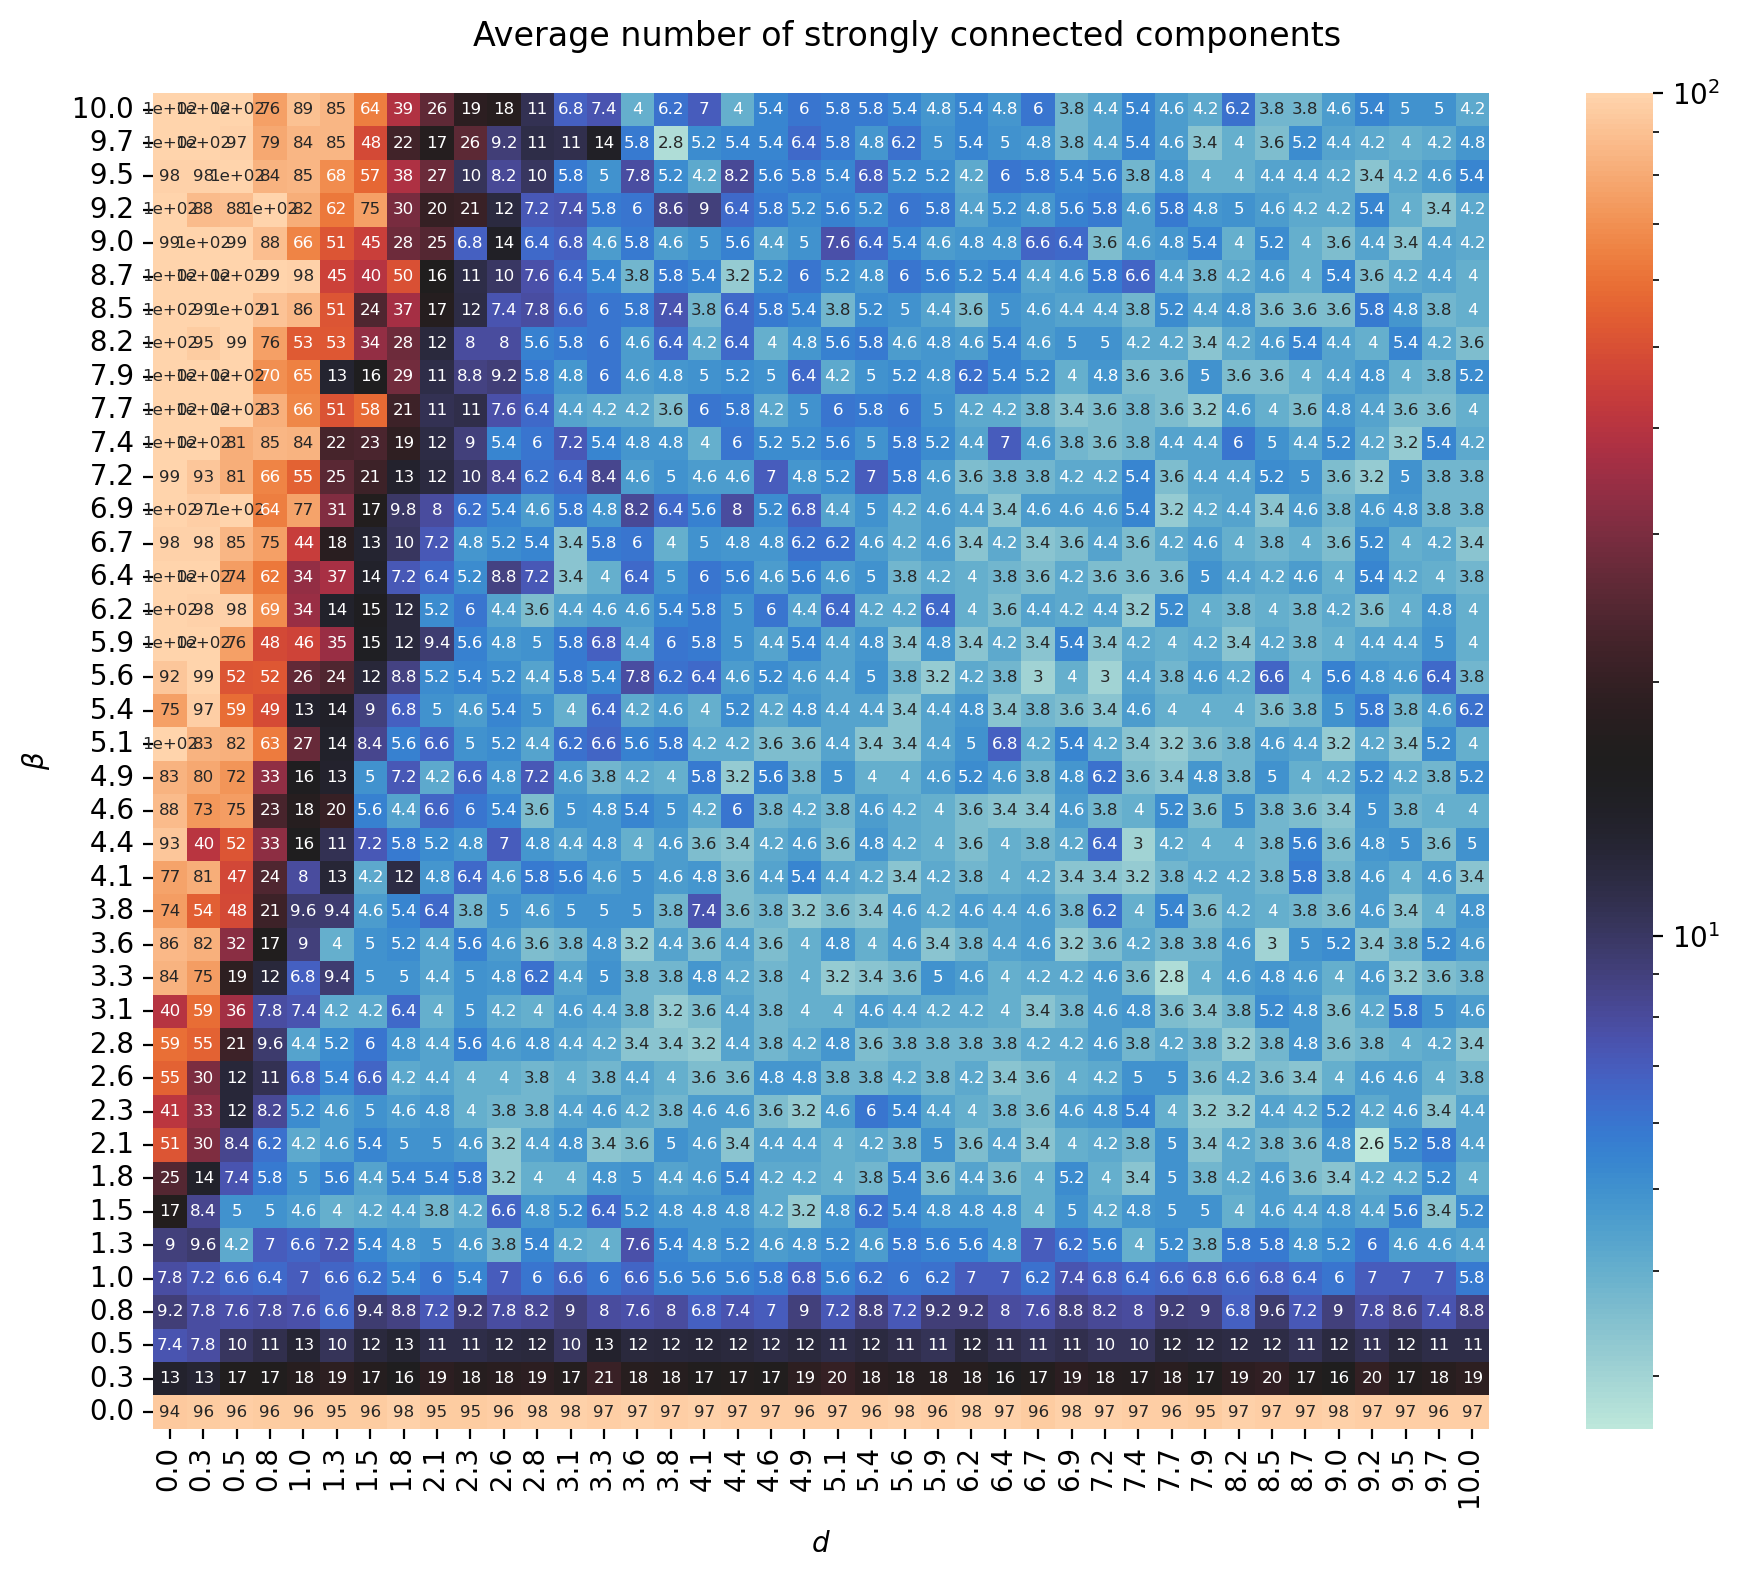

In [130]:
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(10,8),layout='tight',dpi=200)
fig.suptitle('Average number of strongly connected components')
from matplotlib.colors import LogNorm
sns_kwargs = dict(square = True,
                  cmap = 'icefire', 
                  xticklabels = d_st, #[f'{dist[i]:.1f}' if i%2==0 else '' for i in range(len(d_st))], 
                  yticklabels = b_st,
                  vmin=0.8,vmax=100.2,
                  annot=True, annot_kws=dict(size=6),
                  norm=LogNorm()
                  )
sns.heatmap(psarr[:,:,4], **sns_kwargs, ax = ax)

ax.invert_yaxis()
#a.invert_xaxis()
ax.set_xlabel('$d$')
ax.set_ylabel('$\\beta$')

Text(112.8777777777778, 0.5, '$\\beta$')

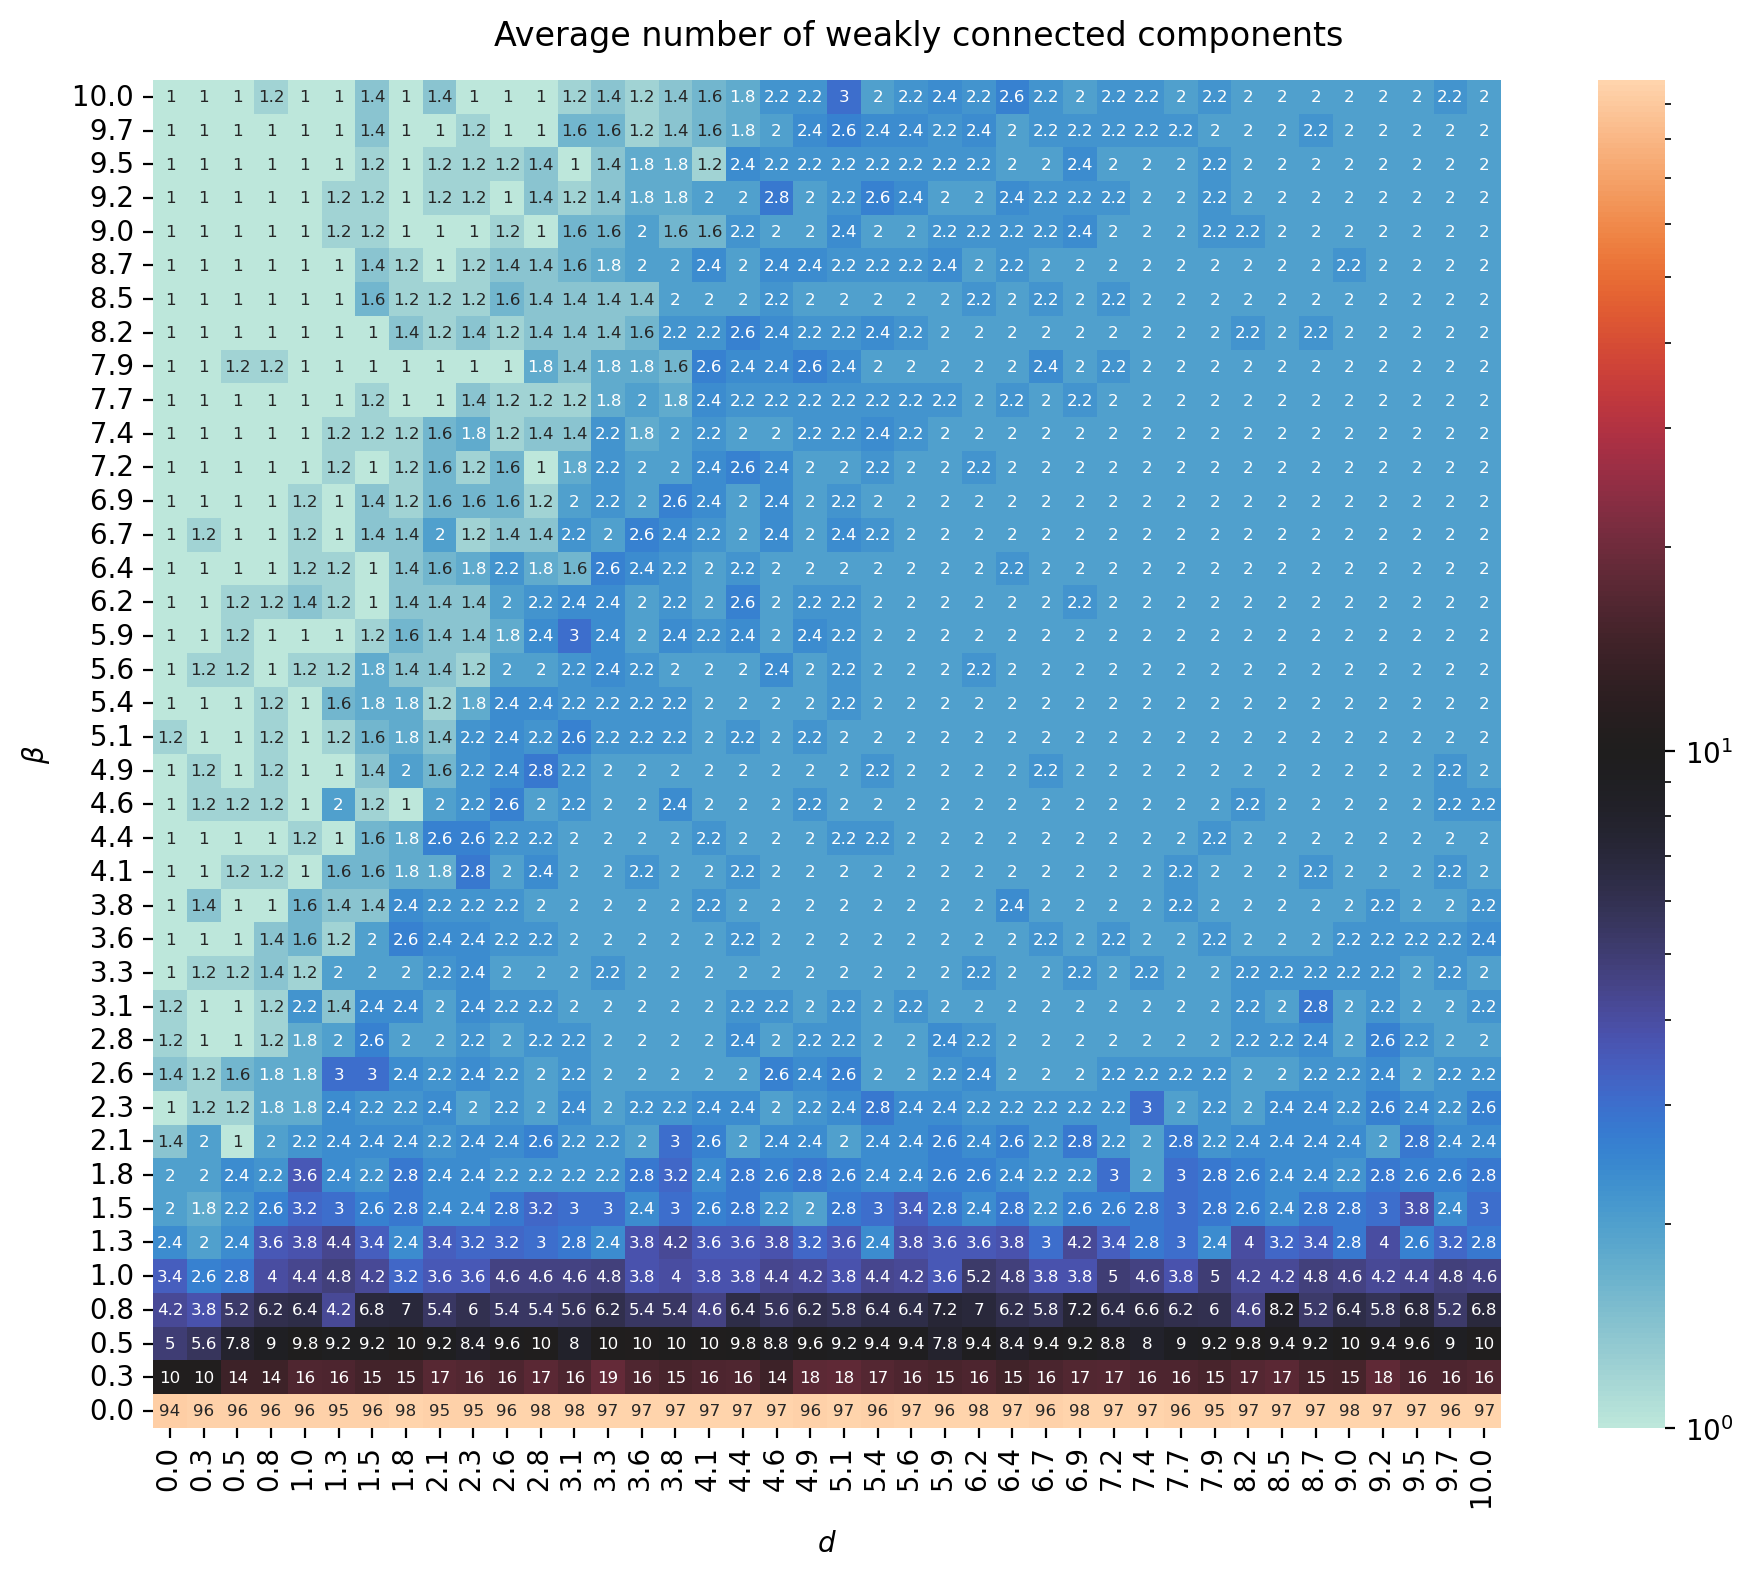

In [132]:
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(10,8),layout='tight',dpi=200)
fig.suptitle('Average number of weakly connected components')
from matplotlib.colors import LogNorm
sns_kwargs = dict(square = True,
                  cmap = 'icefire', 
                  xticklabels = d_st[:], 
                  yticklabels = b_st,
                  vmin=0.8,vmax=100.2,
                  annot=True, annot_kws=dict(size=6),
                  norm=LogNorm()
                  )
sns.heatmap(psarr[:,:,5], **sns_kwargs, ax = ax)
#ax[0].set_xticks()

ax.invert_yaxis()
#a.invert_xaxis()
ax.set_xlabel('$d$')
ax.set_ylabel('$\\beta$')

What I think it says: when beta is too low, no one talks to anyone, and all 

In [48]:
os.environ.get('USER')

'daniele'

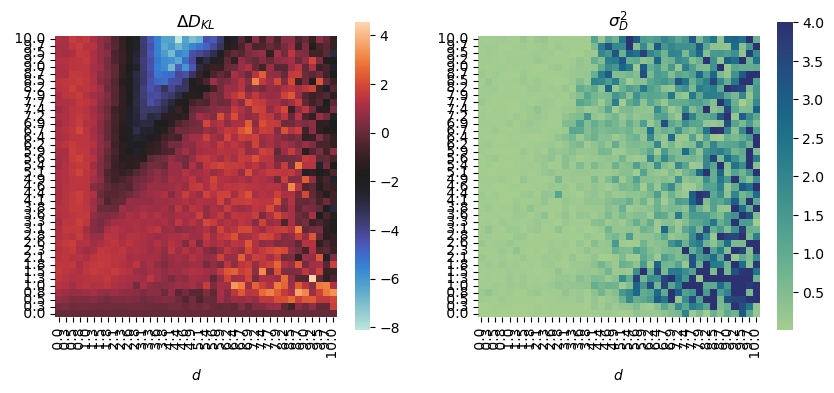

In [60]:
fig, ax = plt.subplots(1,2, figsize = (10,4))

sns.heatmap(psarr[:,:,2]-psarr[:,:,0], square = True, cmap = 'icefire', xticklabels = d_st, yticklabels = b_st, ax = ax[0])
sns.heatmap(psarr[:,:,3], vmax = 4, square = True, cmap = 'crest', xticklabels = d_st, yticklabels = b_st, ax = ax[1])

ax[0].set_title('$\\Delta D_{KL}$')
ax[1].set_title('$\\sigma^{2}_{D}$')

for a in ax:

    a.invert_yaxis()
    #a.invert_xaxis()

    a.set_xlabel('$d$')

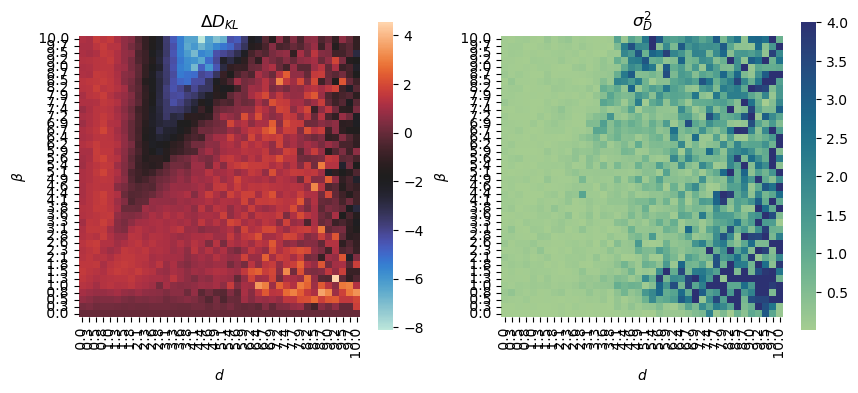

In [63]:
DV = psarr[:,:,2]
DV0 = psarr[:,:,0]
DV_var = psarr[:,:,3]
fig, ax = plt.subplots(1,2, figsize = (10,4))

sns.heatmap(DV-DV0, square = True, cmap = 'icefire', xticklabels = d_st, yticklabels = b_st, ax = ax[0])
sns.heatmap(DV_var, vmax = 4, square = True, cmap = 'crest', xticklabels = d_st, yticklabels = b_st, ax = ax[1])

ax[0].set_title('$\\Delta D_{KL}$')
ax[1].set_title('$\\sigma^{2}_{D}$')

for a in ax:

    a.invert_yaxis()
    #a.invert_xaxis()

    a.set_xlabel('$d$')
    a.set_ylabel('$\\beta$')

#plt.savefig('aaa.png', dpi = 300)